In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# --- GRR Primitives ---
def grr_perturb(x, domain, epsilon):
    domain = list(domain)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    if np.random.rand() < p:
        return x
    return np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    domain = list(domain)
    n = len(reports)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    q = 1.0 / (exp_eps + k - 1)

    counts = {v: 0 for v in domain}
    for r in reports:
        if r in counts:
            counts[r] += 1
        else:
            raise ValueError(f"Reported value '{r}' not in domain")

    return {v: (counts[v] - n * q) / (n * (p - q)) for v in domain}

In [3]:
def random_split_perturb(df, epsilon):
    """
    Each user perturbs all attributes using equal budget split.
    """
    k = len(df.columns)
    eps_attr = epsilon / k
    perturbed = []

    for _, row in df.iterrows():
        noisy_row = [
            grr_perturb(row[col], df[col].unique(), eps_attr)
            for col in df.columns
        ]
        perturbed.append(noisy_row)
    
    return perturbed

def random_split_estimate(reports, df, epsilon):
    """
    Estimate frequencies for each attribute independently.
    """
    k = len(df.columns)
    eps_attr = epsilon / k
    reports = np.array(reports)
    estimates = {}

    for i, col in enumerate(df.columns):
        domain = df[col].unique()
        col_reports = reports[:, i]
        estimates[col] = grr_estimate_frequencies(col_reports, domain, eps_attr)

    return estimates


In [4]:
def rs_fd_perturb(df, domains, epsilon):
    n, d = df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)  # Correct ε′
    epsilon_prime = epsilon
    cols = list(domains.keys())
    
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)
        output = {}
        for i, col in enumerate(cols):
            domain = domains[col]
            if i == j:
                output[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                output[col] = np.random.choice(domain)
        privatized.append(output)
    
    return pd.DataFrame(privatized, index=df.index)


def rs_fd_estimate(perturbed_df, domains, epsilon):
    n, d = perturbed_df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)  # Correct ε′
    epsilon_prime = epsilon
    estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        p = np.exp(epsilon_prime) / (np.exp(epsilon_prime) + kj - 1)
        q = 1.0 / (np.exp(epsilon_prime) + kj - 1)

        counts = perturbed_df[col].value_counts().to_dict()

        est = {}
        for v in domain:
            Ni = counts.get(v, 0)
            est[v] = (Ni * d * kj - n * (d - 1 + q * kj)) / (n * kj * (p - q))
        estimates[col] = est

    return estimates




In [5]:
def rs_rfd_perturb(df, domains, priors, epsilon):
    """
    RS+RFD[GRR] client-side perturbation.

    Args:
        df       : DataFrame of true user data.
        domains  : dict mapping each attribute to its domain.
        priors   : dict of prior distributions (same structure as output of get_true_frequencies).
        epsilon  : privacy budget.

    Returns:
        DataFrame of privatized data.
    """
    n, d = df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    cols = list(df.columns)
    epsilon_prime = epsilon
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)  # index of sampled attribute
        y = {}
        for i, col in enumerate(cols):
            domain = domains[col]
            if i == j:
                # Sanitize sampled attribute with GRR
                y[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                # Fake value sampled from prior
                prior_probs = [priors[col].get(v, 0.0) for v in domain]
                prior_probs = np.array(prior_probs)
                prior_probs /= prior_probs.sum()  # ensure normalization
                y[col] = np.random.choice(domain, p=prior_probs)
        privatized.append(y)

    return pd.DataFrame(privatized, index=df.index)
def rs_rfd_estimate(perturbed_df, domains, priors, epsilon):
    """
    RS+RFD[GRR] server-side frequency estimator.

    Args:
        perturbed_df : output of rs_rfd_perturb.
        domains      : dict of attribute → domain list.
        priors       : dict of attribute → {value: prior prob}.
        epsilon      : same ε used in perturbation.

    Returns:
        dict of attribute → {value: estimated frequency}.
    """
    n, d = perturbed_df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    epsilon_prime = epsilon
    estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        exp_eps = np.exp(epsilon_prime)
        p = exp_eps / (exp_eps + kj - 1)
        q = (1 - p) / (kj - 1)

        counts = perturbed_df[col].value_counts().to_dict()
        est = {}
        for v in domain:
            C_vi = counts.get(v, 0)
            f_prior = priors[col].get(v, 0.0)
            bias = q + (d - 1) * f_prior
            numerator = d * C_vi - n * bias
            denominator = n * (p - q)
            est[v] = numerator / denominator
        estimates[col] = est

    return estimates


In [6]:
import numpy as np
import pandas as pd

# --- p_y Optimization Function ---
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 1
    return float(np.clip(p_star, 0.0, 1.0))

# --- Phase 1 SPL ---
def corr_rr_phase1_spl(df, epsilon, frac=0.1):
    n = len(df)
    m = int(frac * n)
    df_A = df.iloc[:m]
    eps_split = epsilon / df.shape[1]
    
    reports = []
    for _, row in df_A.iterrows():
        reports.append([
            grr_perturb(row[col], df[col].unique(), eps_split)
            for col in df.columns
        ])
    reports = np.array(reports)
    
    est = {}
    for i, col in enumerate(df.columns):
        domain = df[col].unique()
        est[col] = grr_estimate_frequencies(reports[:, i], domain, eps_split)
    return est, df.iloc[m:]

# --- Phase 2 Corr-RR Perturbation ---
def corr_rr_phase2_perturb(df, epsilon, f_hat_phase1, domain_map, p_y_table):
    d = len(df.columns)
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)
        perturbed = {}
        for i, col in enumerate(df.columns):
            domain = domain_map[col]
            if i == j:
                perturbed[col] = grr_perturb(row[col], domain, epsilon)
            else:
                pair = (df.columns[j], col)
                py = p_y_table.get(pair, 0.5)
                if np.random.rand() < py:
                    perturbed[col] = row[col]
                else:
                    perturbed[col] = np.random.choice([v for v in domain if v != row[col]])
        privatized.append(perturbed)
    return pd.DataFrame(privatized, index=df.index)

# --- Corr-RR Estimator (using standard GRR) ---
def corr_rr_estimate(perturbed_df, domains, epsilon):
    estimates = {}
    n, d = perturbed_df.shape
    for col, domain in domains.items():
        reports = perturbed_df[col].tolist()
        estimates[col] = grr_estimate_frequencies(reports, domain, epsilon)
    return estimates

# --- Weighted Merge of Phase Estimates ---
def combine_phase_estimates(est_A, est_B, m, n_minus_m):
    combined = {}
    for col in est_A:
        combined[col] = {}
        for v in est_A[col]:
            combined[col][v] = (m * est_A[col][v] + n_minus_m * est_B[col][v]) / (m + n_minus_m)
    return combined


In [ ]:
# --- Cond-RR for binary 2-attr ---
def rr_estimate(reports, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    n = len(reports)
    return (sum(reports) - n*q) / (n*(p - q))

def cond_rr_estimate(data, epsilon, m):
    n = len(data)
    eps_half = epsilon/2
    # phase1
    spl = np.array([[grr_perturb(x, [0,1], eps_half) for x in r] for r in data[:m]])
    counts = {(0,0):0,(0,1):0,(1,0):0,(1,1):0}
    for r in spl: counts[tuple(r)] += 1
    Y = np.array([counts[k]/m for k in counts])
    p = np.exp(eps_half)/(np.exp(eps_half)+1)
    q = 1-p
    M = np.array([[p*p, p*q, q*p, q*q],
                  [p*q, p*p, q*q, q*p],
                  [q*p, q*q, p*p, p*q],
                  [q*q, q*p, p*q, p*p]])
    P = np.clip(np.linalg.inv(M).dot(Y), 0, None)
    P /= P.sum()
    P00,P01,P10,P11 = P
    c2_1 = {0:P00/(P00+P01) if P00+P01>0 else .5,
            1:P10/(P10+P11) if P10+P11>0 else .5}
    c1_2 = {0:P00/(P00+P10) if P00+P10>0 else .5,
            1:P01/(P01+P11) if P01+P11>0 else .5}
    f1_s = rr_estimate(spl[:,0], eps_half)
    f2_s = rr_estimate(spl[:,1], eps_half)
    rr_reports = {1:[],2:[]}
    syn_reports = {1:[],2:[]}
    for x1,x2 in data[m:]:
        if np.random.rand()<.5:
            y1 = grr_perturb(x1, [0,1], epsilon)
            y2 = np.random.choice([0,1], p=[c2_1[y1],1-c2_1[y1]])
            rr_reports[1].append(y1); syn_reports[2].append(y2)
        else:
            y2 = grr_perturb(x2, [0,1], epsilon)
            y1 = np.random.choice([0,1], p=[c1_2[y2],1-c1_2[y2]])
            rr_reports[2].append(y2); syn_reports[1].append(y1)
    est = {}
    for j, f_s in [(1,f1_s),(2,f2_s)]:
        n_rr,len_syn = len(rr_reports[j]), len(syn_reports[j])
        f_rr = rr_estimate(rr_reports[j], epsilon) if n_rr>0 else 0
        f_syn= np.mean(syn_reports[j]) if len_syn>0 else 0
        est[j] = (m*f_s + n_rr*f_rr + len_syn*f_syn)/n
    return np.array([est[1], est[2]])

In [7]:
# --- True Frequency Utility ---
def get_true_frequencies(df, columns):
    freq_dict = {}
    for col in columns:
        counts = df[col].value_counts(normalize=True).sort_index()
        freq_dict[col] = counts.to_dict()
    return freq_dict

def correlated_data_generator(domain, n, correlations=None, total_attributes=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    domain = list(domain)
    domain_set = {x: [d for d in domain if d != x] for x in domain}
    df = pd.DataFrame()

    # Add correlated attributes
    if correlations:
        for attr1, attr2, p_same in correlations:
            X1 = np.random.choice(domain, size=n)
            mask = np.random.rand(n) < p_same
            X2 = np.where(mask, X1, [np.random.choice(domain_set[v]) for v in X1])
            df[attr1] = X1
            df[attr2] = X2

    # Decide which attributes to include
    if total_attributes is not None:
        all_attrs = [f'X{i+1}' for i in range(total_attributes)]
    else:
        all_attrs = list(df.columns)

    for attr in all_attrs:
        if attr not in df.columns:
            df[attr] = np.random.choice(domain, size=n)

    return df

# domain = [0, 1, 2, 3]
# correlations = [('X1', 'X2', 0.9), ('X3', 'X4', 0.9)]

# df = correlated_data_generator(domain, n=1000, correlations=correlations, total_attributes=2, seed=42)
# print(df.columns)  # ['X1', 'X2']
# print(df.head())

In [37]:

# 0.98, 0.95, 0.93, 0.91, 

domain = [0, 1]
correlations = [('X1', 'X2', 0.93)]

df = correlated_data_generator(domain, n=10000, correlations=correlations, total_attributes=2, seed=42)
print(df.columns)  # ['X1', 'X2']
print(df.head())

Index(['X1', 'X2'], dtype='object')
   X1  X2
0   0   0
1   1   1
2   0   0
3   0   0
4   0   0


In [101]:
# --- Cond-RR for binary 2-attr ---
def rr_estimate(reports, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    n = len(reports)
    return (sum(reports) - n*q) / (n*(p - q))

def cond_rr_estimate(data, epsilon, m):
    n = len(data)
    eps_half = epsilon/2
    # phase1
    spl = np.array([[grr_perturb(x, [0,1], eps_half) for x in r] for r in data[:m]])
    counts = {(0,0):0,(0,1):0,(1,0):0,(1,1):0}
    for r in spl: counts[tuple(r)] += 1
    Y = np.array([counts[k]/m for k in counts])
    p = np.exp(eps_half)/(np.exp(eps_half)+1)
    q = 1-p
    M = np.array([[p*p, p*q, q*p, q*q],
                  [p*q, p*p, q*q, q*p],
                  [q*p, q*q, p*p, p*q],
                  [q*q, q*p, p*q, p*p]])
    P = np.clip(np.linalg.inv(M).dot(Y), 0, None)
    P /= P.sum()
    P00,P01,P10,P11 = P
    c2_1 = {0:P00/(P00+P01) if P00+P01>0 else .5,
            1:P10/(P10+P11) if P10+P11>0 else .5}
    c1_2 = {0:P00/(P00+P10) if P00+P10>0 else .5,
            1:P01/(P01+P11) if P01+P11>0 else .5}
    f1_s = rr_estimate(spl[:,0], eps_half)
    f2_s = rr_estimate(spl[:,1], eps_half)
    rr_reports = {1:[],2:[]}
    syn_reports = {1:[],2:[]}
    for x1,x2 in data[m:]:
        if np.random.rand()<.5:
            y1 = grr_perturb(x1, [0,1], epsilon)
            y2 = np.random.choice([0,1], p=[c2_1[y1],1-c2_1[y1]])
            rr_reports[1].append(y1); syn_reports[2].append(y2)
        else:
            y2 = grr_perturb(x2, [0,1], epsilon)
            y1 = np.random.choice([0,1], p=[c1_2[y2],1-c1_2[y2]])
            rr_reports[2].append(y2); syn_reports[1].append(y1)
    est = {}
    for j, f_s in [(1,f1_s),(2,f2_s)]:
        n_rr,len_syn = len(rr_reports[j]), len(syn_reports[j])
        f_rr = rr_estimate(rr_reports[j], epsilon) if n_rr>0 else 0
        f_syn= np.mean(syn_reports[j]) if len_syn>0 else 0
        est[j] = (m*f_s + n_rr*f_rr + len_syn*f_syn)/n
    return np.array([est[1], est[2]])


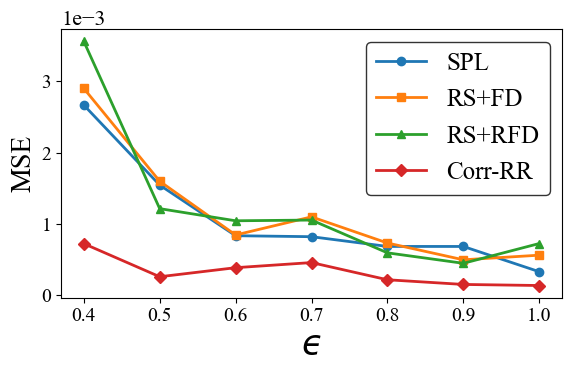

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(2))
correlations = [('X1', 'X2', 0.98)]
epsilons = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n = 10000
m = 0.1

R = 20  # number of independent runs

# containers for all runs
all_spl    = np.zeros((R, len(epsilons)))
all_rsfd   = np.zeros((R, len(epsilons)))
all_rsrfd  = np.zeros((R, len(epsilons)))
all_corrrr = np.zeros((R, len(epsilons)))

for run in range(R):
    # regenerate (or reuse) data
    df = correlated_data_generator(domain,n, correlations=correlations)
    columns = df.columns.tolist()
    true_freqs = get_true_frequencies(df, columns)
    priors = true_freqs
    domain_sorted = sorted(domain)
    domains = {col: sorted(df[col].unique()) for col in columns}

    mse_spl    = []
    mse_rsfd   = []
    mse_rsrfd  = []
    mse_corrrr = []

    for eps in epsilons:
        # SPL
        pert_spl = random_split_perturb(df, eps)
        est_spl  = random_split_estimate(pert_spl, df, eps)
        mse_spl.append(np.mean([
            np.mean([(est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, eps)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, eps)
        mse_rsfd.append(np.mean([
            np.mean([(est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # RS + RFD
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, eps)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, eps)
        mse_rsrfd.append(np.mean([
            np.mean([(est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=0.1)
        n_A = int(m * len(df))
        n_B = len(df_B)
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, eps)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr.append(np.mean([
            np.mean([(combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

    # record this run’s results
    all_spl[run, :]    = mse_spl
    all_rsfd[run, :]   = mse_rsfd
    all_rsrfd[run, :]  = mse_rsrfd
    all_corrrr[run, :] = mse_corrrr

# compute the average MSE across runs
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)

# --- Plot only the mean curves ---
plt.figure(figsize=(6, 4))


# save to SVG:

plt.plot(epsilons, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(epsilons, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(epsilons, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(epsilons, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')
#plt.plot(epsilons, mean_corrrr, '-h', linewidth=2, markersize=6, label='Cond-RR')


plt.xlabel(r'$ϵ$', fontsize=25)
plt.ylabel('MSE', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.legend(fontsize=18, loc='upper right', frameon=True, edgecolor='black')
#plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.savefig("/Users/shafizurrahmanseeam/Desktop/plots//mse_plot_c_95.svg", format="svg")

plt.show()


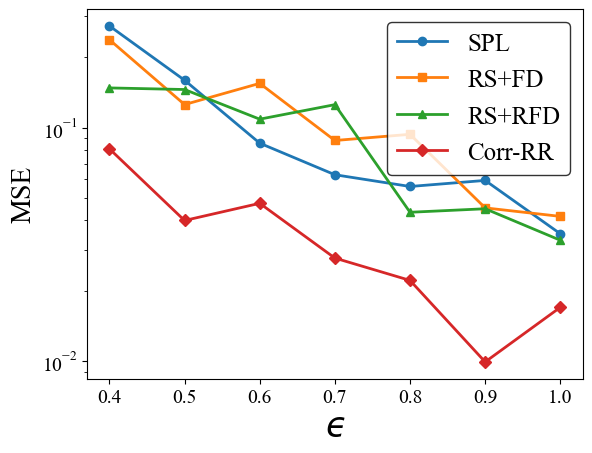

In [114]:
plt.plot(epsilons, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(epsilons, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(epsilons, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(epsilons, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')
#plt.plot(epsilons, mean_corrrr, '-h', linewidth=2, markersize=6, label='Cond-RR')


plt.xlabel(r'$ϵ$', fontsize=25)
plt.ylabel('MSE', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.yscale('log')
plt.legend(fontsize=18, loc='upper right', frameon=True, edgecolor='black')

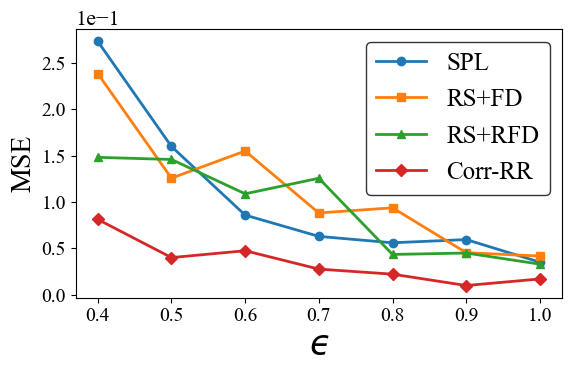

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(2))
correlations = [('X1', 'X2', 0.95)]
epsilons = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n = 100
m = 0.1

R = 20  # number of independent runs

# containers for all runs
all_spl    = np.zeros((R, len(epsilons)))
all_rsfd   = np.zeros((R, len(epsilons)))
all_rsrfd  = np.zeros((R, len(epsilons)))
all_corrrr = np.zeros((R, len(epsilons)))

for run in range(R):
    # regenerate (or reuse) data
    df = correlated_data_generator(domain,n, correlations=correlations)
    columns = df.columns.tolist()
    true_freqs = get_true_frequencies(df, columns)
    priors = true_freqs
    domain_sorted = sorted(domain)
    domains = {col: sorted(df[col].unique()) for col in columns}

    mse_spl    = []
    mse_rsfd   = []
    mse_rsrfd  = []
    mse_corrrr = []

    for eps in epsilons:
        # SPL
        pert_spl = random_split_perturb(df, eps)
        est_spl  = random_split_estimate(pert_spl, df, eps)
        mse_spl.append(np.mean([
            np.mean([(est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, eps)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, eps)
        mse_rsfd.append(np.mean([
            np.mean([(est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # RS + RFD
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, eps)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, eps)
        mse_rsrfd.append(np.mean([
            np.mean([(est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=0.1)
        n_A = int(m * len(df))
        n_B = len(df_B)
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, eps)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr.append(np.mean([
            np.mean([(combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

    # record this run’s results
    all_spl[run, :]    = mse_spl
    all_rsfd[run, :]   = mse_rsfd
    all_rsrfd[run, :]  = mse_rsrfd
    all_corrrr[run, :] = mse_corrrr

# compute the average MSE across runs
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)

# --- Plot only the mean curves ---
plt.figure(figsize=(6, 4))


# save to SVG:

plt.plot(epsilons, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(epsilons, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(epsilons, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(epsilons, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')
#plt.plot(epsilons, mean_corrrr, '-h', linewidth=2, markersize=6, label='Cond-RR')


plt.xlabel(r'$ϵ$', fontsize=25)
plt.ylabel('MSE', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.legend(fontsize=18, loc='upper right', frameon=True, edgecolor='black')
#plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.savefig("/Users/shafizurrahmanseeam/Desktop/plots//mse_plot_c_90.svg", format="svg")

plt.show()


In [110]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(2))
correlations = [('X1', 'X2', 0.93)]
epsilons = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n = 10000
m = 0.1

R = 20  # number of independent runs

# containers for all runs
all_spl    = np.zeros((R, len(epsilons)))
all_rsfd   = np.zeros((R, len(epsilons)))
all_rsrfd  = np.zeros((R, len(epsilons)))
all_corrrr = np.zeros((R, len(epsilons)))

for run in range(R):
    # regenerate (or reuse) data
    df = correlated_data_generator(domain,n, correlations=correlations)
    columns = df.columns.tolist()
    true_freqs = get_true_frequencies(df, columns)
    priors = true_freqs
    domain_sorted = sorted(domain)
    domains = {col: sorted(df[col].unique()) for col in columns}

    mse_spl    = []
    mse_rsfd   = []
    mse_rsrfd  = []
    mse_corrrr = []

    for eps in epsilons:
        # SPL
        pert_spl = random_split_perturb(df, eps)
        est_spl  = random_split_estimate(pert_spl, df, eps)
        mse_spl.append(np.mean([
            np.mean([(est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, eps)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, eps)
        mse_rsfd.append(np.mean([
            np.mean([(est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # RS + RFD
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, eps)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, eps)
        mse_rsrfd.append(np.mean([
            np.mean([(est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=0.1)
        n_A = int(m * len(df))
        n_B = len(df_B)
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, eps)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr.append(np.mean([
            np.mean([(combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

    # record this run’s results
    all_spl[run, :]    = mse_spl
    all_rsfd[run, :]   = mse_rsfd
    all_rsrfd[run, :]  = mse_rsrfd
    all_corrrr[run, :] = mse_corrrr

# compute the average MSE across runs
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)

# --- Plot only the mean curves ---
plt.figure(figsize=(6, 4))


# save to SVG:

plt.plot(epsilons, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(epsilons, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(epsilons, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(epsilons, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')
#plt.plot(epsilons, mean_corrrr, '-h', linewidth=2, markersize=6, label='Cond-RR')


plt.xlabel(r'$ϵ$', fontsize=25)
plt.ylabel('MSE', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.legend(fontsize=18, loc='upper right', frameon=True, edgecolor='black')
#plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.savefig("/Users/shafizurrahmanseeam/Desktop/plots//mse_plot_c_85.svg", format="svg")

plt.show()


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
domain = list(range(2))
correlations = [('X1', 'X2', 0.91)]
epsilons = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n = 10000
m = 0.1

R = 20  # number of independent runs

# containers for all runs
all_spl    = np.zeros((R, len(epsilons)))
all_rsfd   = np.zeros((R, len(epsilons)))
all_rsrfd  = np.zeros((R, len(epsilons)))
all_corrrr = np.zeros((R, len(epsilons)))

for run in range(R):
    # regenerate (or reuse) data
    df = correlated_data_generator(domain,n, correlations=correlations)
    columns = df.columns.tolist()
    true_freqs = get_true_frequencies(df, columns)
    priors = true_freqs
    domain_sorted = sorted(domain)
    domains = {col: sorted(df[col].unique()) for col in columns}

    mse_spl    = []
    mse_rsfd   = []
    mse_rsrfd  = []
    mse_corrrr = []

    for eps in epsilons:
        # SPL
        pert_spl = random_split_perturb(df, eps)
        est_spl  = random_split_estimate(pert_spl, df, eps)
        mse_spl.append(np.mean([
            np.mean([(est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # RS + FD
        pert_rsfd = rs_fd_perturb(df, domains, eps)
        est_rsfd  = rs_fd_estimate(pert_rsfd, domains, eps)
        mse_rsfd.append(np.mean([
            np.mean([(est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # RS + RFD
        pert_rsrfd = rs_rfd_perturb(df, domains, priors, eps)
        est_rsrfd  = rs_rfd_estimate(pert_rsrfd, domains, priors, eps)
        mse_rsrfd.append(np.mean([
            np.mean([(est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

        # Corr-RR (two-phase)
        phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=0.1)
        n_A = int(m * len(df))
        n_B = len(df_B)
        p_y_table = {
            (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
            for a in columns for b in columns if a != b
        }
        pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
        est_corr_rr  = corr_rr_estimate(pert_corr_rr, domains, eps)
        combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)
        mse_corrrr.append(np.mean([
            np.mean([(combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0))**2
                     for v in domain_sorted])
            for col in columns
        ]))

    # record this run’s results
    all_spl[run, :]    = mse_spl
    all_rsfd[run, :]   = mse_rsfd
    all_rsrfd[run, :]  = mse_rsrfd
    all_corrrr[run, :] = mse_corrrr

# compute the average MSE across runs
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)

# --- Plot only the mean curves ---
plt.figure(figsize=(6, 4))


# save to SVG:

plt.plot(epsilons, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(epsilons, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(epsilons, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(epsilons, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')
#plt.plot(epsilons, mean_corrrr, '-h', linewidth=2, markersize=6, label='Cond-RR')


plt.xlabel(r'$ϵ$', fontsize=25)
plt.ylabel('MSE', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.legend(fontsize=18, loc='upper right', frameon=True, edgecolor='black')
#plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.savefig("/Users/shafizurrahmanseeam/Desktop/plots//mse_plot_c_80.svg", format="svg")

plt.show()


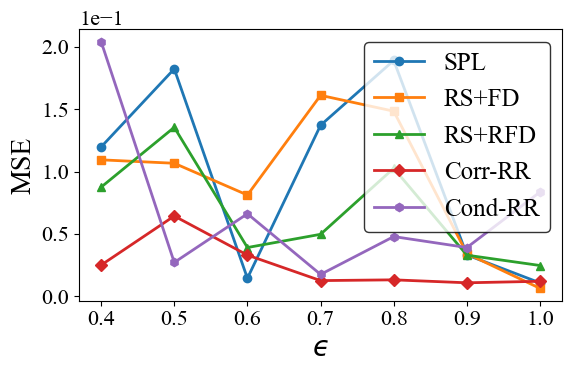

In [105]:
# --- Simulation & MSE collection ---
domain      = list(range(2))
correlations= [('X1','X2',0.98)]
epsilons    = [0.4,0.5,0.6,0.7,0.8,0.9,1.0]
n           = 100
m_frac      = 0.1
R           = 2

all_spl    = np.zeros((R, len(epsilons)))
all_rsfd   = np.zeros((R, len(epsilons)))
all_rsrfd  = np.zeros((R, len(epsilons)))
all_corrrr = np.zeros((R, len(epsilons)))
all_condrr = np.zeros((R, len(epsilons)))

for run in range(R):
    df         = correlated_data_generator(domain, n, correlations=correlations)
    cols       = df.columns.tolist()
    true_freqs = get_true_frequencies(df, cols)
    priors     = true_freqs
    domain_sorted = sorted(domain)
    domains    = {c: sorted(df[c].unique()) for c in cols}
    m_count    = int(m_frac * len(df))

    mse_spl    = []
    mse_rsfd   = []
    mse_rsrfd  = []
    mse_corrrr = []
    mse_condrr = []

    for eps in epsilons:
        # SPL
        pert = random_split_perturb(df, eps)
        est  = random_split_estimate(pert, df, eps)
        mse_spl.append(np.mean([
            np.mean([(est[c].get(v,0)-true_freqs[c].get(v,0))**2 for v in domain_sorted])
            for c in cols
        ]))

        # RS+FD
        pert = rs_fd_perturb(df, domains, eps)
        est  = rs_fd_estimate(pert, domains, eps)
        mse_rsfd.append(np.mean([
            np.mean([(est[c].get(v,0)-true_freqs[c].get(v,0))**2 for v in domain_sorted])
            for c in cols
        ]))

        # RS+RFD
        pert = rs_rfd_perturb(df, domains, priors, eps)
        est  = rs_rfd_estimate(pert, domains, priors, eps)
        mse_rsrfd.append(np.mean([
            np.mean([(est[c].get(v,0)-true_freqs[c].get(v,0))**2 for v in domain_sorted])
            for c in cols
        ]))

        # Corr-RR
        estA, dfB = corr_rr_phase1_spl(df, eps, frac=m_frac)
        nA = m_count; nB = len(dfB)
        p_table = {
            (a,b): optimal_p_y(estA[a], estA[b], eps, nA, domain_sorted)
            for a in cols for b in cols if a!=b
        }
        pert = corr_rr_phase2_perturb(dfB, eps, estA, domains, p_table)
        estB = corr_rr_estimate(pert, domains, eps)
        comb = combine_phase_estimates(estA, estB, nA, nB)
        mse_corrrr.append(np.mean([
            np.mean([(comb[c].get(v,0)-true_freqs[c].get(v,0))**2 for v in domain_sorted])
            for c in cols
        ]))

        # Cond-RR
        vals = cond_rr_estimate(df.values, eps, m_count)
        estC = {
            cols[0]: {0:1-vals[0], 1:vals[0]},
            cols[1]: {0:1-vals[1], 1:vals[1]}
        }
        mse_condrr.append(np.mean([
            np.mean([(estC[c].get(v,0)-true_freqs[c].get(v,0))**2 for v in domain_sorted])
            for c in cols
        ]))

    all_spl[run]    = mse_spl
    all_rsfd[run]   = mse_rsfd
    all_rsrfd[run]  = mse_rsrfd
    all_corrrr[run] = mse_corrrr
    all_condrr[run] = mse_condrr

# --- Compute means and plot ---
mean_spl    = all_spl.mean(axis=0)
mean_rsfd   = all_rsfd.mean(axis=0)
mean_rsrfd  = all_rsrfd.mean(axis=0)
mean_corrrr = all_corrrr.mean(axis=0)
mean_condrr = all_condrr.mean(axis=0)

plt.figure(figsize=(6,4))
plt.plot(epsilons, mean_spl,    '-o', linewidth=2, markersize=6, label='SPL')
plt.plot(epsilons, mean_rsfd,   '-s', linewidth=2, markersize=6, label='RS+FD')
plt.plot(epsilons, mean_rsrfd,  '-^', linewidth=2, markersize=6, label='RS+RFD')
plt.plot(epsilons, mean_corrrr, '-D', linewidth=2, markersize=6, label='Corr-RR')
plt.plot(epsilons, mean_condrr, '-h', linewidth=2, markersize=6, label='Cond-RR')
plt.xlabel(r'$ϵ$', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(fontsize=18, loc='upper right', frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()







In [104]:
import matplotlib as mpl

# --- set global font to Times New Roman ---
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,            # switch to True if you have a TeX installation
    'font.size': 16,                 # fallback for general text
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.titlesize': 20,
})